# A PINN example to estimate sliding from surface observations

## Set-Up of the Problem

The problem: We have observations of surface heights, surface speed (from satellites), and estimates of ice thickness, but we don't know how fast ice is sliding on its bed. We can use physics: momentum balance (i.e., stress balance equations) to infer basal sliding from these surface observations.

This document is a tutorial for the implementation of a PINN solver for infering basal friction coefficients using Shelfy-Stream Approximation (SSA): 

***We use Shelfy-Stream Approximation (SSA): 
<br>
$$\nabla \cdot \sigma _{SSA} + \tau_b = \rho_igH\nabla s,\; in\; \Omega$$
<br>
where $\tau_b$  is the basal shear stress, determined by a friction law:
<br>
$$\tau_b =  −C^2|u|^{m − 1}u$$
<br>
with the a calving front boundary condition:
<br>
$$ \sigma\cdot n = (\bar{p}_i -\bar{p}_w)n on \; \Gamma$$
<br> 
We can infer the basal friction coefficient ($C$) from known observations of surface velocity ($\hat{u}$), ice thickness ($\hat{h}$), and surface elevation ($\hat{s}$) using the PINN while learning its observational data***

[click for deepxde examples](https://deepxde.readthedocs.io/en/latest/)

DeepXDE is a library for scientific machine and physics-informed learning.
<br>
DeepXDE includes algorithms for:
<br>
$\star$ Solving different problems (such as: ordinary/partial differential equations, integro-differential equations,etc.)
<br>
$\star$ Improving PINN accuracy (such as: residual-based adaptive sampling, gradient-end PINN, PINN with multi-scale Fourier features, etc.)
<br>
$\star$ Physics-informed deep operator network (DeepONet)(such as: DeepONet: learning operators, MIONet: learning multiple-input operators, reliable extrapolation, etc.) 
<br>
$\star$ Multifidelity Neural Network (MFNN) (such as learning from multifidelity data)


## PINN Solver Code

**Import the necessary packages:**

In [1]:
%reset -f
import pinnicle as pinn
import os
import numpy as np
from datetime import datetime
import deepxde as dde

2024-05-26 23:00:21.526258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 23:00:21.646901: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



**Let's set configuration for DeepXDE(dde):**

In [2]:
dde.config.set_default_float('float64')
dde.config.disable_xla_jit()
dde.config.set_random_seed(1234)

Disable just-in-time compilation with XLA.



Set the default float type to float64


**Create the Experiment**

In [3]:
# create experiments
datestr = datetime.now().strftime("%Y%m%d_%H%M%S")

**Create data file and path:**

In [4]:
# data file and path
inputFileName="Upernavik_ForSade.mat"
expFileName = "Upernavik-Copy1.exp"

In [5]:
#inputFileName="Helheim_fastflow.mat"
#expFileName = "Helheim_Big.exp"
repoPath = "./examples/"
appDataPath = os.path.join(repoPath, "dataset")
data_path = os.path.join(appDataPath, inputFileName)

# check
print(data_path)

./examples/dataset/Upernavik_ForSade.mat


**Create a path for saving results and figures:**

In [6]:
# path for saving results and figures
outputFileName="Upernavik_test"
#outputFileName="Helheim_test"
modelFolder = "./Models/" + outputFileName + "_" + datestr  + "/"

**Set the general parameters for training:**
<br>
PINNICLE has hyperparameters stored in a dictionary, ```hp```, with specific names. PINNICLE loads the parameters from ```hp``` according to the corresponding keys. 
<br>
[Click here for more details on PINN's default and required parameters](https://pinnicle.readthedocs.io/en/latest/api/pinnicle.html#pinnicle.parameter.DataParameter)


In [7]:
# General parameters
hp = {}
hp["epochs"] = 1000000
hp["learning_rate"] = 0.001
hp["loss_function"] = "MSE"
hp["save_path"] = modelFolder
hp["is_save"] = True
hp["is_plot"] = True

**Set Neural Network's Architecture within ```hp```:**
<br>
 We are going to use Hyperbolic Tangent functions for activation functions, we will use 6 layers with 20 neurons each and a Glorot uniform initializer.

In [8]:
# NN
hp["activation"] = "tanh"
hp["initializer"] = "Glorot uniform"
hp["num_neurons"] = 20
hp["num_layers"] = 6

**Create the domain of the computation:**
<br>
We define the domain of computation, and number of collocation points used to evaluate the PDEs residual.

In [9]:
# domain
hp["shapefile"] = os.path.join(repoPath, "dataset", expFileName)
hp["num_collocation_points"] = 5000

**Add the physics components, ``SSA``, to the PINN:**


In [10]:
# physics
MC = {}
MC["scalar_variables"] = {"B":1.26802073401e+08}
hp["equations"] = {"MC":MC}

**There are default parameter settings in ```SSA``` such as:
<br>**

In [11]:
def set_default(self):
    self.input = ['x', 'y']
    self.output = ['u', 'v', 's', 'H', 'C']
    self.output_lb = [-1.0e4/self.yts, -1.0e4/self.yts, -1.0e3, 10.0, 0.01]
    self.output_ub = [ 1.0e4/self.yts,  1.0e4/self.yts,  2.5e3, 2000.0, 1.0e4]
    self.data_weights = [1.0e-8*self.yts**2.0, 1.0e-8*self.yts**2.0, 1.0e-6, 1.0e-6, 1.0e-8]
    self.residuals = ["fSSA1", "fSSA2"]
    self.pde_weights = [1.0e-10, 1.0e-10]

    # scalar variables: name:value
    self.scalar_variables = {
            'n': 3.0,               # exponent of Glen's flow law
            'B':1.26802073401e+08   # -8 degree C, cuffey
            }

These default parameters are the names of the input and output variables in the PINN, scaling factors, weights in the loss function, and names of the residual and weights. 
<br>
<br>
We can set the input and output names as any other names. But, the orders of the input and output lists matters. These input and output lists will be used to load the data in the next section:

**Set the Data used for training in ```issm``` dictionary:**
<br>


In [12]:
# data
issm = {}
issm["data_size"] = {"u":1000, "v":1000, "a":1000, "H":None}
issm["data_path"] = data_path
hp["data"] = {"ISSM":issm}

**In ```data_size``` the variables are defined by pairs of ```key``` = ```value```. If keys are not redefined in ```name_map``` then they will be set as the default or what they  are set as in the physics section.** 
<br>
The value associated with each key gives the number of data points used for the training. When ```value``` is set as **None**, then only Dirichlet boundary condition around the domain boundary will be used for the corresponding ```key```. If the variable is included in the training, but not given in ```data_size```, then there will be no data used in the training for this variable. 

**Create the Experiment and Compile:** Now, let's run the PINN model.
<br>

In [13]:
# create experiment
experiment = pinn.PINN(hp)
print(experiment.params)
experiment.compile()

ERROR:root:ERROR: MATLAB type not supported: bamggeom, (uint32)
ERROR:root:ERROR: MATLAB type not supported: bamgmesh, (uint32)
ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)
2024-05-26 23:00:25.911779: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-26 23:00:25.911832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3445 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


add input transform with [ -323028.74554883 -1870413.49271111] and [ -230318.78353497 -1740472.47370953]
add output transform with [-3.17097920e-04 -3.17097920e-04 -1.58548960e-07  1.62696374e-01] and [3.1709792e-04 3.1709792e-04 1.5854896e-07 2.5000000e+03]
Parameters: 
	TrainingParameter: 
		epochs:	1000000
		optimizer:	adam
		loss_functions:	['MSE', 'MSE', 'MSE', 'MSE', 'MSE']
		additional_loss:	{}
		learning_rate:	0.001
		loss_weights:	[1000000.0, 31536.0, 31536.0, 315360000000.0, 1e-06]
		has_callbacks:	False
		min_delta:	None
		patience:	None
		period:	None
		checkpoint:	False
		save_path:	./Models/Upernavik_test_20240526_230023/
		is_save:	True
		is_plot:	True
	DomainParameter: 
		shapefile:	./examples/dataset/Upernavik-Copy1.exp
		num_collocation_points:	5000
	DataParameter: 
		ISSM:
			data_path:	./examples/dataset/Upernavik_ForSade.mat
			data_size:	{'u': 1000, 'v': 1000, 'a': 1000, 'H': None}
			name_map:	{'u': 'u', 'v': 'v', 'a': 'a', 'H': 'H'}
			source:	ISSM

	NNParameter

**Train the experiment:**

In [ ]:
# Train
experiment.train()

Training model...



/opt/conda/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Step      Train loss                                            Test loss                                             Test metric
0         [2.53e-07, 1.16e-04, 1.81e-05, 4.39e-04, 5.87e-01]    [2.53e-07, 1.16e-04, 1.81e-05, 4.39e-04, 5.87e-01]    []  
10000     [2.47e-07, 2.08e-06, 8.22e-07, 3.51e-05, 5.49e-03]    [2.47e-07, 2.08e-06, 8.22e-07, 3.51e-05, 5.49e-03]    []  
20000     [2.63e-07, 2.26e-06, 8.22e-07, 3.32e-05, 4.00e-03]    [2.63e-07, 2.26e-06, 8.22e-07, 3.32e-05, 4.00e-03]    []  
30000     [3.22e-07, 2.31e-06, 8.15e-07, 3.16e-05, 2.47e-03]    [3.22e-07, 2.31e-06, 8.15e-07, 3.16e-05, 2.47e-03]    []  


#### The results should look like this: 
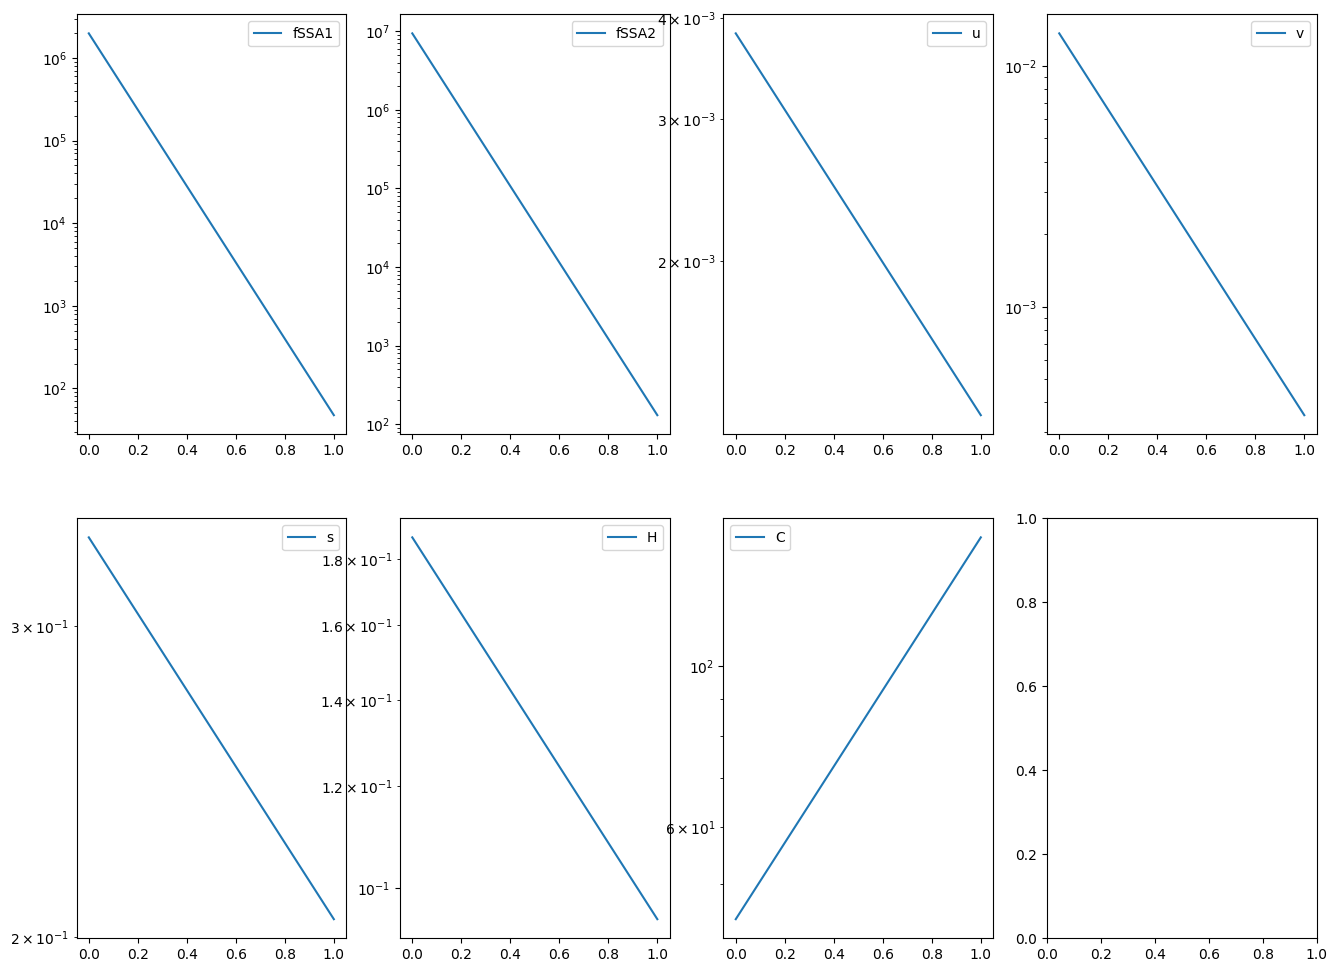

**Show the results with ```experiment.plot_predictions()```:**
<br>


### The results should look like: 
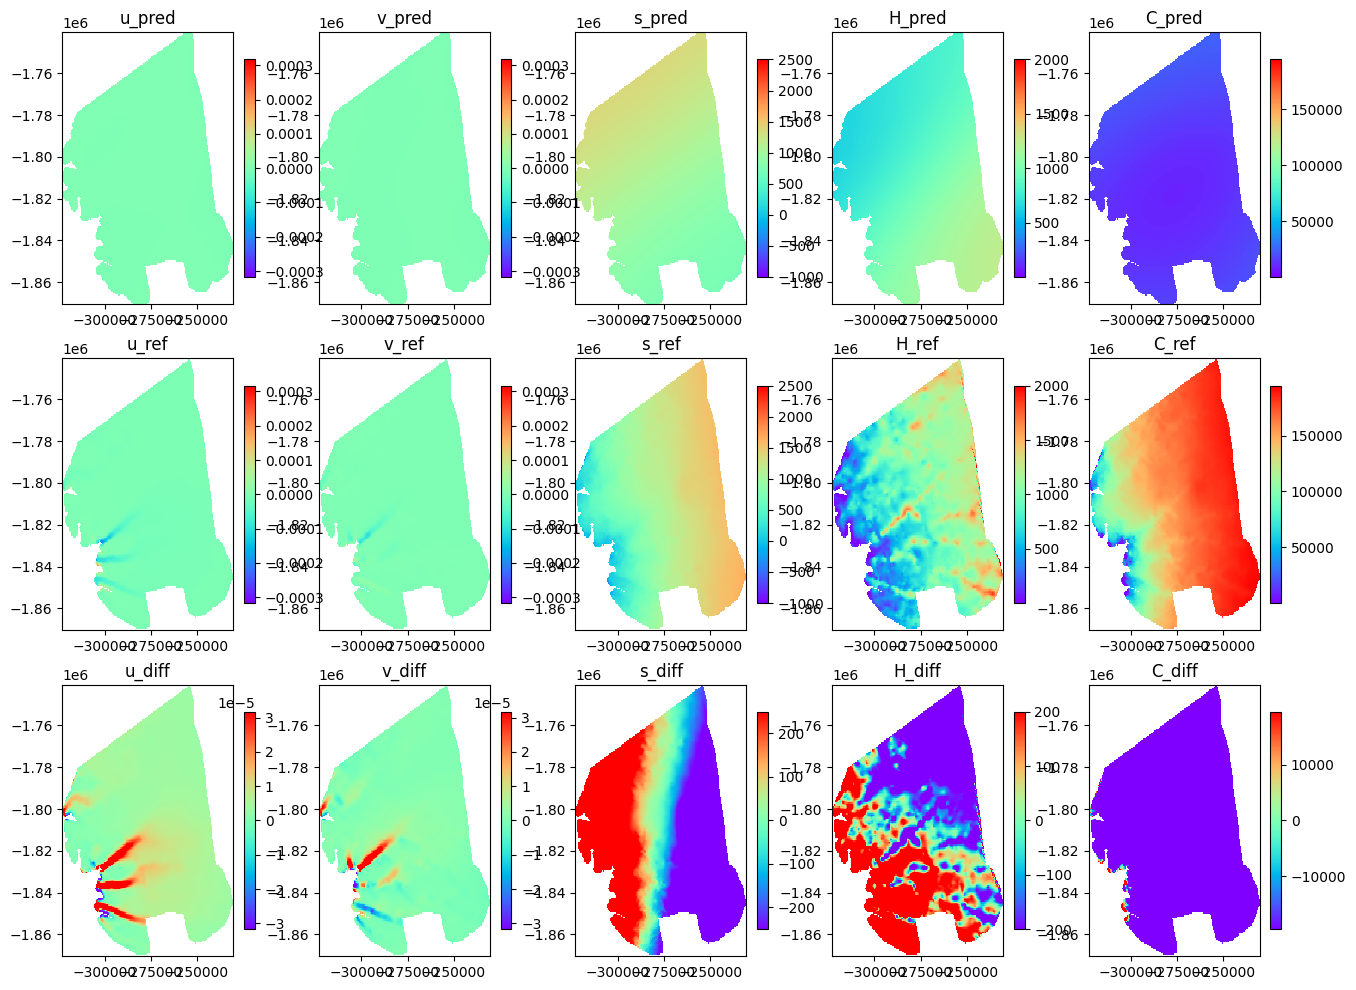

In [ ]:
# show results
experiment.plot_predictions(X_ref=experiment.model_data.data["ISSM"].X_dict, 
                            sol_ref=experiment.model_data.data["ISSM"].data_dict)

**Use ```plot_similarity``` to plot the difference between predicted and refrence values for $H$**

In [ ]:
pinn.utils.plotting.plot_similarity(pinn=experiment,feature_name = 'H', cmap='terrain')